# <center>How Does Curricular Complexity Affect Time-to-Degree?</center>
## <center> Study Design </center>


The following Julia programming language packages will be used in the analyses provided in this notebook:

In [189]:
using CurricularAnalytics, CurricularVisualization
using DataFrames
using GLM
using StatsBase
using Plots
using CSV
using LaTeXStrings

### A Logistic Regression Model
We will model the relationship between curricular complexity and time-to-degree using regression techniques, with the dependent variable being whether or not a student graduated within a particular timeframe, and the independent variable being the curricular (i.e., structural) complexity. Because the dependent variables are dichotomous, i.e., a student either graduates or not within a given time period, we will apply *logistic regression* in order to deal with this nonlinearity. Later we will include other independent variables related to student demographics and preparation, instructional complexity, institutional support, etc. 

Consider first the relationship between program curricular complexity and the probability that a student will be able to graduate from that program within four years. We will use $Y=1$ is a binary outcome variable that indicates a student was able to gradaute within four years, and $Y=0$ to denote a student was *not* able to graduate within fours. I.e., $Y$ is treated as the outcome of a Bernoulli trial. Thus, we are interested in using previously collected student data to estimate:
$$
   \mbox{Prob}\{Y | X\}. 
$$

Logistic regression is commonly used to create a model for "explaining" how variances in binary dependent variables relate to changes in the independent variables. Logistic regression makes use of the logistic function, expressed as: 
$$ 
\begin{equation}
 \mbox{Prob}\{Y=1| X\} = \left[1 + e^{-(b_0 + b_1X)}\right]^{-1}.
 \label{logistic}
\end{equation}
$$
A graph of the function 
$$
 P = \left[1 + e^{-x}\right]^{-1}
$$
is shown in the figure below.

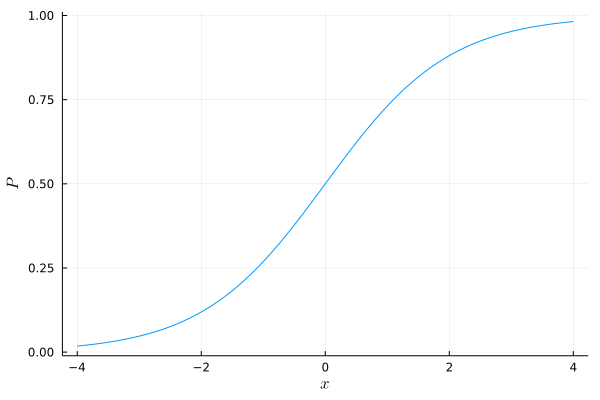

In [45]:
X = [i*0.1 for i in -40:40]
Y = [1/(1+exp(-x)) for x in X]
plot(X, Y, seriestype = :line, xlabel = latexstring("x"), ylabel=latexstring("P"), legend=false)

Notice that this transformation maps any $x$ value in $(-\infty, \infty)$ to a $P$ value in $[0,1]$.  Notice also that there is a region of $x$, from about -1.5 to 1.5, that is roughly linear, and where a small change in $x$ yields a large change in $P$.  This is also the behavior we see on test data when we compare compare graduation rates to curricular complexity.  That is, there is a linear region, of intermediate curricular complexities values, where small changes in curricular complexity yeild large changes in student success (i.e., graduation rates), but at very low and very high curricular complexity values, small changes in curricular complexity produce small changes in student success. At the extremes, almost everyone graduates within four years (low curricular complexity) or almost nobody graduates within four years (high curricular complexity).

Solving the logistic function for $x$ yields the inverse logistic function, also know as the logistic transformation (or *logit* for short). Specifically,
$$ 
 \begin{eqnarray}
 \ln P & = & \ln\left({1 \over 1 + e^{-x}}\right) = \ln\left({e^x \over 1 + e^{x}}\right) \\
       & = & \ln e^x - \ln(1 + e^x) \\
       & = & x + \ln\left({1 \over 1 + e^{x}}\right) \\
       & = & x - \ln(1-P)
 \end{eqnarray}
$$
and therefore
$$
  x = \ln\left({P \over 1-P}\right).
$$

This logit equation has an interesting, and important, interpretation. Specifically, if we treat $P_i$ as the probability of an event $i$ occurring, then the quantity $P_i/(1-P_i)$ corresponds to the *odds* of an event $i$ occurring, and the *logged odds* for that event is defined as:
$$
   L_i = \log \left[{P_i \over 1-P_i} \right].
$$

The purpose of logistic regression is to estimate the $P_i$ values (i.e., the probability of graduating within a given timeframe) from observed data. This is accomplished by determing the $b_0$ and $b_1$ coefficients in the logistic equation provided above through maximum likelihood estimation. 

### Data Requirements
The data that will be used to estimate these coefficients should be collected as follows. First, the analysis is backwards looking, which means the cohort should be defined as follows: Start with everyone who graduated in a given term, and then look backwards to see which first-time full-time (FTFT) cohort they belonged to. If they don’t belong to a FTFT cohort, they should be excluded from the data (i.e., the analysis should focus on full-time students).  From this you should compute how many years it took each student to graduate.  

A sample spreadsheet with the required fields is supplied with this notebook. This spreadsheet contains the following data fields (columns):

- program_code: a short-hand (unique) code used to refer to the program. This may be used in visualizations. 
- program_name: the actual name of the program. 
- complexity_score: computed from supplied curricular data
- total_degrees_awarded: total number of graduates from the program over the terms considered.
- less_than_four: count of those in the cohort who graduated in less than four years
- four: count of those in the cohort who graduated within four years (this includes the less_than_four students)
- four_and_half: count of those in the cohort who graduated within four-and-one-half years
- five: count of those in the cohort who graduated within five years
- five_and_half: count of those in the cohort who graduated within five-and-one-half years
- six: count of those in the cohort who graduated within six  

**A Note on Sample Size.**
It is important to collect a sufficient amount of data in order to obtain accurate estimates of the coefficietns. A discussion of sufficient sample size statistics is beyond the scope of this notebook, but as a rule of thumb, the goal should be to collect on the order of thousands of samples across a large range of programs with different curricular complexity values. In practice this typically involves collecting 6-10 terms worth of graduation data across all of the undergraduate programs at a given institution.

For a semester-based institution, 6-10 terms corresponds to 3-5 years worth of data.  Given that programs often change their requirements over time, this introduces the problem of a program's curricular compleixty possibly changing over the data collection period. Rather than trying to track which students graduated from particular versions of a program, it may be easiest to simply average the curricular complexity scores of a program over time, and treat this as a small amount of noise in the data.

# Introduction
The goal of this study is to investigate the various factors that influence the amount of time it takes for students to earn an undergraduate degree, i.e., time-to-degree.  Clearly, there are many factors influencing time-to-degree, including a student's prior preparation, students changing majors, student employment, internships, institutional support, etc. In this notebook we investigate the influence of curricular complexity, and in particular structural complexity, on time-to-degree.  

The first portion of this study involves determining the impact of a program's structural complexity on a student's ability to graduate from that program within 4, 5, and 6 years. This portion of the study does *not* take into account student or institutional characteristics. This portion of the work will set the baseline for determining how additional factors influence the aforementioned graduation rates. Thus, if $X$ denotes the curricular (structural) complexity of a particular academic program, we'd like to determine its causal affect on the program's graduation rate, which can be represented as a causal diagram:
![XY](./XY-causal.pdf)
which should be read as "$X$ has a causal impact on $Y$." The variable $Y$ in this case corresponds to the time-to-degree for a given student, given that they graduated from a program with structural complexity $X$. The variable $U$ shown in this figure is meant to model unknown influences on the graduation rates (e.g., background preparation, motivation, etc.), and we will elaborate them in subsequent work.

As mentioned above, there are likely many other "confounding" factors that impact a student's ability to graduate within a given timeframe. These will be considered in the sequel, as we build upon the initial causal model shown above.

In this model, we treat both $X$ and $U$ as direct causes of $Y$, where $U$ are unmeasured factors (i.e., random exogenous causes), leading to the following initial structural causal model.

$$
 U = \{U_1, U_2, \ldots \} ~\\
 V = \{Y\}
$$

### Example – University of Arizona
Graduation data over the past four years (2016-2020) was collected from the University of Arizona.  All undergraduate programs at the university currently in existance are included in this data set.  In order to work with this data set, we will read them into a data frame.

In [116]:
df = DataFrame(CSV.File("./Complexity_x_Grad_UA.csv"))
# showall(df)  #uncomment to show the entire dataframe

,program_code,program_name,sub-plan_code,sub-plan_name
,String,String,String,String
1,BNADBSBA,Business Administration,-,Not Available
2,BIOINBS,Bioinformatics,CSCI,Computer Science
3,LAWBA,Law,-,Not Available
4,SYEBSSYE,Systems Engineering,-,Not Available
5,GNSBGS,General Studies,AMENT,"Arts, Media and Entertainment"
6,ECEBSECE,Electrical & Computer Engineer,-,Not Available
7,ENGLBA,English,-,Not Available
8,GEOSBS,Geosciences,GEO,Geology
9,PHILBA,Philosophy,ETHICS,Ethics


## Analyses
The complexity distrubtion of the undergraduate programs at the Unviersity of Arizona are as follows. Notice that there are numerous low complexity programs at the Univeristy of Arizona, and fewer high complexity programs. This power-law distribution is commonly observed when considering all of the curricula provided by an instituion. 

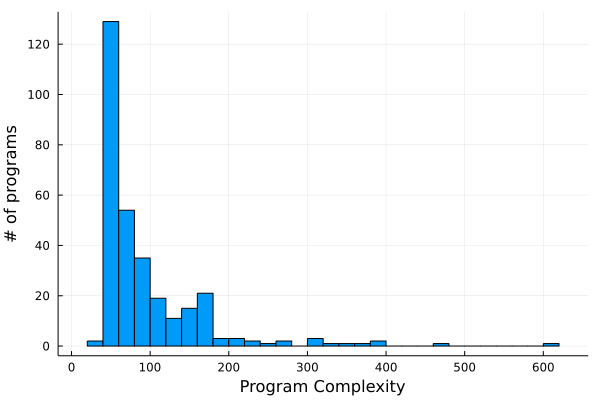

In [117]:
histogram(df.complexity_score, nbins=50, xlabel="Program Complexity", ylabel="# of programs", label="")

Next we extract the information we need from this data set in order to perform logistic regression and we place it into a new data frame containing one entry per student considered in the original data set:

In [118]:
X = Array{Integer,1}() # curricular complexity score of program
Y = Array{Bool,1}() # did student graduate within 4 years?
Z = Array{Bool,1}() # did student graduate within 6 years?
for row in eachrow(df)
  for t in 1:row["four"] 
    push!(X, row["complexity_score"])
    push!(Y, 1); push!(Z, 1)
  end
  s = row["total_degrees_awarded"] - row["six"] # number who did not graduate in 6 years or less from program
  for t in 1:(row["total_degrees_awarded"] - row["four"]) # number who did not graduate in 4 years or less from program
    push!(X, row["complexity_score"])
    push!(Y, 0)
    s > 0 ? (push!(Z, 0); s=s-1) : push!(Z, 1)
  end
end
df_binary = DataFrame(Program_Complexity = X, grad4 = Y, grad6 = Z);

Next, consider the number of students who gradauted from the programs provided at the Univeristy of Arizona. When compared to the prior chart, this chart indicates a slight bias towards students graduating from higher complexity programs.  This phenomena warrants further investigation.

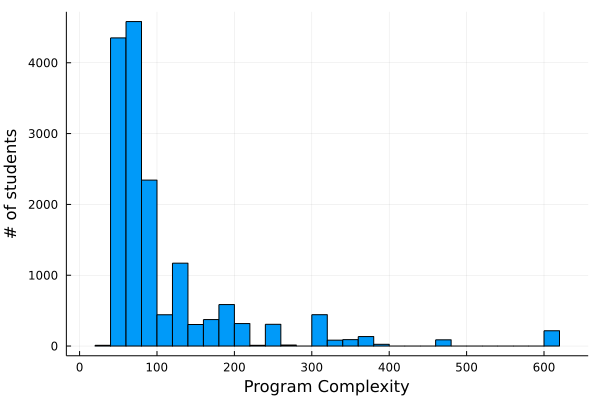

In [120]:
histogram(X, nbins=50, xlabel="Program Complexity", ylabel="# of students", label="")

### Creating the Logistic Regression Model
Logistic regression was implemented using a Generalized Linar Model (GLM) with a logit link function. The logit4 and logit6 models shown below relate curricular complexity to graduates who were able to complete their degrees in four and six years, respectively.

In [162]:
logit4 = glm(@formula(grad4 ~ Program_Complexity), df_binary, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

grad4 ~ 1 + Program_Complexity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                          Coef.   Std. Error      z  Pr(>|z|)    Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)          1.0632      0.0262812    40.45    <1e-99   1.01169      1.11471
Program_Complexity  -0.00115154  0.000173629  -6.63    <1e-10  -0.00149185  -0.000811233
────────────────────────────────────────────────────────────────────────────────────────

In [163]:
logit6 = glm(@formula(grad6 ~ Program_Complexity), df_binary, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

grad6 ~ 1 + Program_Complexity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                          Coef.   Std. Error      z  Pr(>|z|)     Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)         2.78804      0.0528594    52.74    <1e-99   2.68444      2.89164
Program_Complexity  0.000470466  0.000382336   1.23    0.2185  -0.000278899  0.00121983
───────────────────────────────────────────────────────────────────────────────────────

A plot of these models is shown below, where the envelopes show the confidence intervals for these models.  Note that at the University of Arizona, there appears to be a negative effect of curricular complexity on the ability to graduate within four-years, but minimal effect on the ability to gradaute within six-years.  

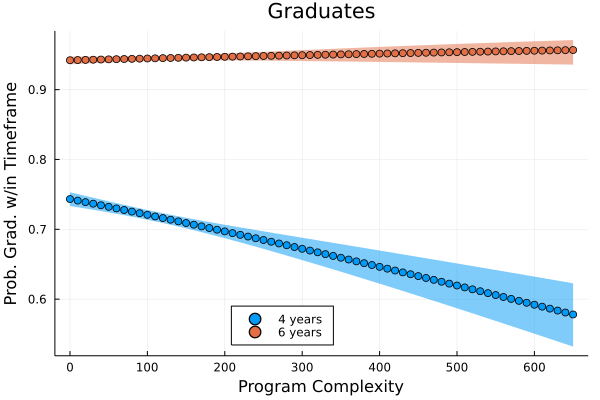

In [164]:
CC_scores = DataFrame(Program_Complexity = 0:10:650)
pred4 = predict(logit4, CC_scores, interval = :confidence)
pred6 = predict(logit6, CC_scores, interval = :confidence)
plot(xlabel="Program Complexity", ylabel="Prob. Grad. w/in Timeframe", title="Graduates", legend=:bottom)
plot!(CC_scores.Program_Complexity, pred4.prediction, seriestype = :scatter, labels="4 years",
       ribbon = (pred4.prediction .- pred4.lower, pred4.upper .- pred4.prediction))
plot!(CC_scores.Program_Complexity, pred6.prediction, seriestype = :scatter, labels="6 years",
       ribbon = (pred6.prediction .- pred6.lower, pred6.upper .- pred6.prediction))

### Other Link Functions
Other link functions can be specified in a GLM in order to create models when the dependent variable is dichotomous. E.g., with the probit link function the cumulative standard normal distribution function, which varies over [0,1], is used to model the regresssion function. Another approach, called Poisson regression, uses a log link function. Models were created using these approaches, and plots of the results are shown below. Notice that all three regression approaches produce nearly identical models.

In [22]:
probit4 = glm(@formula(grad4 ~ Program_Complexity), df_binary, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

grad4 ~ 1 + Program_Complexity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                          Coef.   Std. Error      z  Pr(>|z|)    Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)          0.654872    0.0158034    41.44    <1e-99   0.623898     0.685846
Program_Complexity  -0.00070069  0.000106431  -6.58    <1e-10  -0.00090929  -0.000492089
────────────────────────────────────────────────────────────────────────────────────────

In [23]:
probit6 = glm(@formula(grad6 ~ Program_Complexity), df_binary, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

grad6 ~ 1 + Program_Complexity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                         Coef.   Std. Error      z  Pr(>|z|)     Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)         1.57288     0.0246079    63.92    <1e-99   1.52465      1.62111
Program_Complexity  0.00021193  0.000175364   1.21    0.2268  -0.000131777  0.000555637
───────────────────────────────────────────────────────────────────────────────────────

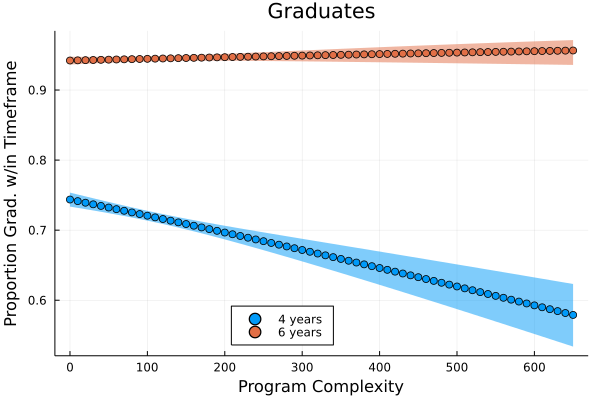

In [24]:
CC_scores = DataFrame(Program_Complexity = 0:10:650)
pred4 = predict(probit4, CC_scores, interval = :confidence)
pred6 = predict(probit6, CC_scores, interval = :confidence)
plot(xlabel="Program Complexity", ylabel="Proportion Grad. w/in Timeframe", title="Graduates", legend=:bottom)
plot!(CC_scores.Program_Complexity, pred4.prediction , seriestype = :scatter, labels="4 years",
       ribbon = (pred4.prediction .- pred4.lower, pred4.upper .- pred4.prediction))
plot!(CC_scores.Program_Complexity, pred6.prediction , seriestype = :scatter, labels="6 years",
       ribbon = (pred6.prediction .- pred6.lower, pred6.upper .- pred6.prediction))

In [26]:
poisson4 = glm(@formula(grad4 ~ Program_Complexity), df_binary, Poisson(), LogLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Poisson{Float64}, LogLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

grad4 ~ 1 + Program_Complexity

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                          Coef.   Std. Error       z  Pr(>|z|)     Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)         -0.292258    0.0142234    -20.55    <1e-93  -0.320136     -0.264381
Program_Complexity  -0.00036219  0.000102223   -3.54    0.0004  -0.000562544  -0.000161836
──────────────────────────────────────────────────────────────────────────────────────────

In [27]:
poisson6 = glm(@formula(grad6 ~ Program_Complexity), df_binary, Poisson(), LogLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Poisson{Float64}, LogLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

grad6 ~ 1 + Program_Complexity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                          Coef.  Std. Error      z  Pr(>|z|)     Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)         -0.0595392   0.0122535   -4.86    <1e-05  -0.0835557    -0.0355227
Program_Complexity   2.44587e-5  8.44797e-5   0.29    0.7722  -0.000141119   0.000190036
────────────────────────────────────────────────────────────────────────────────────────

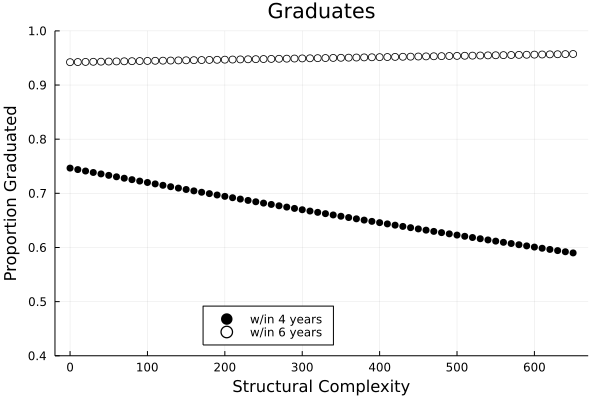

In [28]:
CC_scores = DataFrame(Program_Complexity = 0:10:650)
pred4 = predict(poisson4, CC_scores, interval=:confidence)
pred6 = predict(poisson6, CC_scores, interval=:confidence)
plot(xlabel="Structural Complexity", ylabel="Proportion Graduated", title="Graduates", ylim=(0.4,1.0), legend=:bottom)
plot!(CC_scores.Program_Complexity, pred4.prediction , seriestype=:scatter, labels="w/in 4 years", color=:black)
plot!(CC_scores.Program_Complexity, pred6.prediction , seriestype=:scatter, labels="w/in 6 years", color=:white)

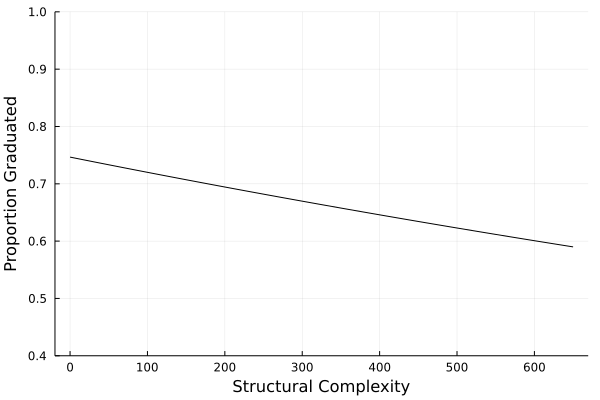

In [159]:
CC_scores = DataFrame(Program_Complexity = 0:10:650)
pred4 = predict(poisson4, CC_scores, interval=:confidence)
plot(xlabel="Structural Complexity", ylabel="Proportion Graduated", ylim=(0.4,1.0), legend=false)
plot!(CC_scores.Program_Complexity, pred4.prediction, seriestype=:line, color=:black)

### Interpretation
These models show that at the Unviversity of Arizona, a 40 point reduction in curricular complexity corresponds to a one percentage point increase in the ability to graduate within four years (see analysis below). 

In [188]:
model(x) = 1/(1+exp(-(coef(logit4)[1] + coef(logit4)[2] * x)))  #using the parameters from the logistic regression model above
model(300) - model(340)

0.010383960884073229

Finally, let's consider the amount of variation explained by these regression models.  With linear models, the $R^2$ value is used to provide such a measure. In particular, $R^2$ describes the proportion of the variation in the dependent variable that can be attributed to the independent variables. This is accomplisthed by measureing how close the observed values of the dependent variable are to the predicted values provided by the linear model. Thus, we can think of $R^2$ as a measure of how much variation the model explains.

For logistic regression models, involving categorial data, a different measure must be developed for explaining variation.  One popular choice, called McFadden's $R^2$ (also know as a "pseudo $R^2$" value) is defined as:
$$ 
\begin{equation}
 R^2_{\mbox{McFadden}} = 1 - {\log L_c \over \log L_{null}}
\end{equation}
$$
where $L_c$ denotes the maximum likelihood values provided by the fitted model, and $L_{null}$ denotes the corresponding null model, i.e., the model produced using only an intercept, and no covariates. Note that $R^2_{\mbox{McFadden}} \in [0,1]$, with 0 indicating that the independent variables in the model explain none of the variation and 1 indicating that explains all of it.


In [186]:
nullmodel4 = glm(@formula(grad4 ~ 1), df_binary, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

grad4 ~ 1

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  0.936374   0.0176352  53.10    <1e-99   0.901809   0.970938
────────────────────────────────────────────────────────────────────────

In [187]:
R_Squared_McFadden4 = 1 - (loglikelihood(logit4)/loglikelihood(nullmodel4))

0.0022605502674980515

Thus, the logistic regresssion model seems to explain a small portion of the variation observed in the graduation time frames.

## References

Heileman, G. L., Abdallah, C.T., Slim, A., and Hickman, M. (2018). Curricular analytics: A framework for quantifying the impact of curricular reforms and pedagogical innovations. www.arXiv.org, arXiv:1811.09676 [cs.CY].